In [1]:
# importing libraries for video extraction
!pip install pafy youtube-dl moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# some other important libraries
import os
import cv2
import pafy
import math
import numpy as np
import datetime as dt
import random
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Downloading UCF50 dataset
It consists of realistic videos taken from Youtube and is a very efficient dataset for action recognition. It contains


*   `50` Action categories
*   `25` Groups of videos for each category
*   `133` Average videos per action category
*   `199` Average number of frames per video
*   `320px` Average frames width per video
*   `240px` Average frames height per video
*   `26` Average FPS per video (high quality)



In [4]:
# downloading the UCF50 dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# extract dataset
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

## Visualization of Dataset
To visualise dataset, I am picking up 20 random categories and a random videom from each selected category. I will visualize the first frame from that videos with the label written

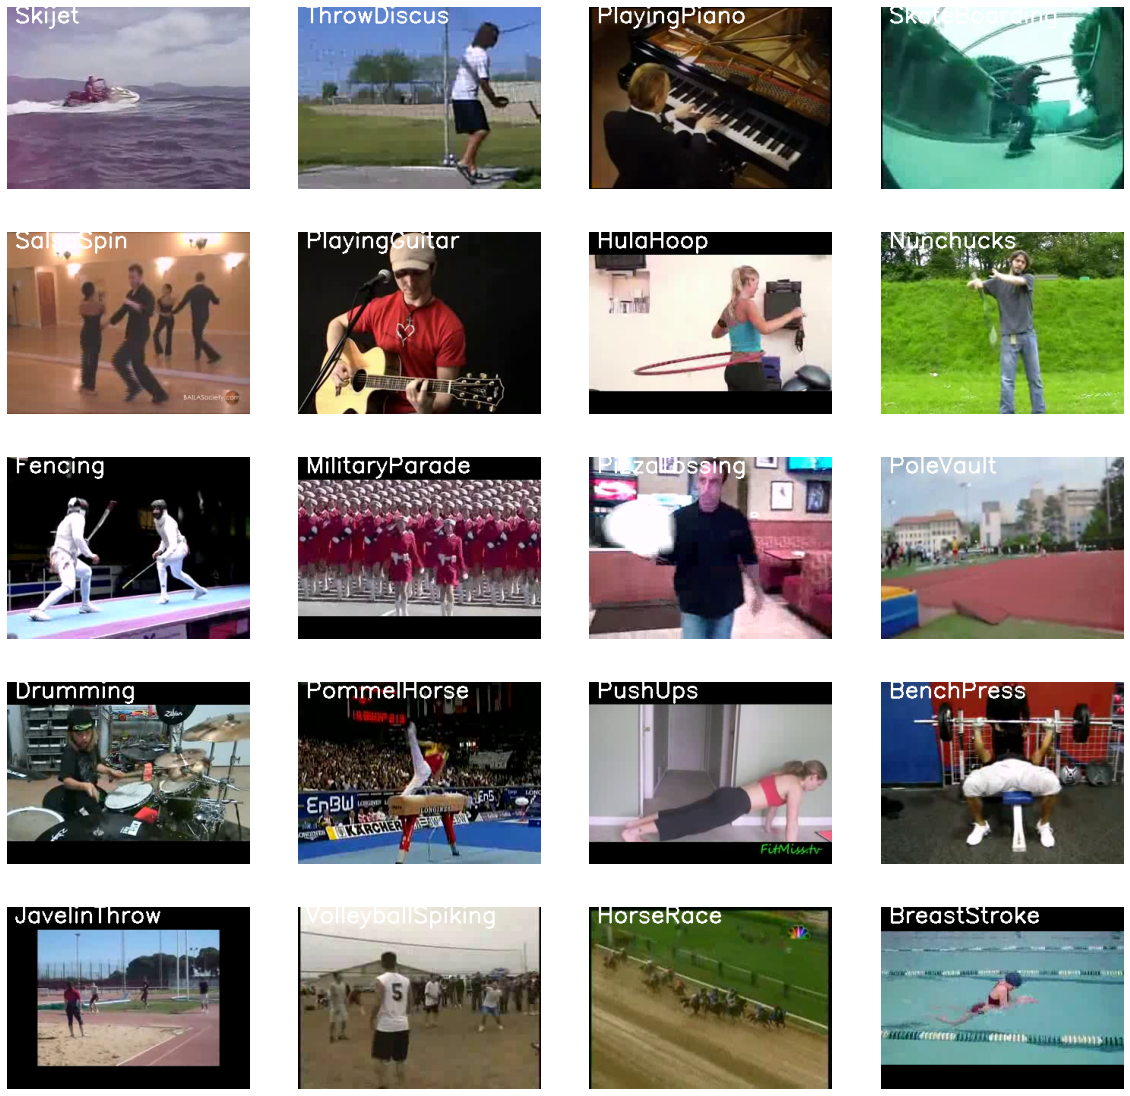

In [5]:
plt.figure(figsize=(20,20))

# getting all class names
all_classes_names = os.listdir('UCF50')

# generating 20 random classes out of 50 total classes
random_range = random.sample(range(len(all_classes_names)),20)

for counter, random_index in enumerate(random_range,1):
  selected_class = all_classes_names[random_index] # retrieving a random class
  video_files_names_list = os.listdir(f'UCF50/{selected_class}') # list of all videos in particular class
  selected_video = random.choice(video_files_names_list) # randomly choose a video
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class}/{selected_video}') # video capture object
  _, bgr_frame = video_reader.read() # read the first frame of video
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB) # convert BGR to RGB format
  cv2.putText(rgb_frame,selected_class,(10,20),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2) # annotating with the class name of video
  
  # plotting the frames with annotated class
  plt.subplot(5,4,counter)
  plt.imshow(rgb_frame)
  plt.axis('off')


## Preprocessing dataset
Now I will normalise the dataset and fix the height and width of all frames to get faster convergence while training

In [4]:
# defining fix height and width of frames
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20 # number of frames of video that will be fed for training as a single sequence. Increasing the length often increases accuracy but at the computational cost
DATASET_DIR = "UCF50"
CLASSES_TO_TAKE = ['WalkingWithDog','TaiChi','Swing','HorseRace']
print(CLASSES_TO_TAKE)
print(len(CLASSES_TO_TAKE))

['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']
4


### Function for frame extraction

In [5]:
# function for resizing and normalising the frames

def frame_extraction(video_path):
  frames = [] # this will contain the final list of frames from a single video
  
  video_reader = cv2.VideoCapture(video_path)
  video_frames_number = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # calculate number of frames in a video
  skip_frames_window = max(int(video_frames_number/SEQUENCE_LENGTH),1)

  # run through each frame in video
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window) 
    success, frame = video_reader.read() # reading frame from video

    if not success: # if frame is not successfully saved
      break

    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH)) # resizing
    normalised_frame = resized_frame/255 # normalisation
    frames.append(normalised_frame)
  
  video_reader.release()
  return frames


### Function for dataset creation 

In [6]:
# function for normalising all the videos in dataset
def create_dataset():
  features = []
  labels = []
  video_files_path = []

  for class_index,class_name in enumerate(CLASSES_TO_TAKE):
    print(f'Extracting data of class -> {class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR,class_name)) # get the list of all videos of particular class

    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)
      frames = frame_extraction(video_file_path) # run the extraction function to extract all the pre processed frames from given video

      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_path.append(video_file_path)

  features = np.asarray(features)
  labels = np.asarray(labels)

  return features,labels,video_files_path



In [7]:
# create the dataset
features, labels, video_files_paths = create_dataset()

Extracting data of class -> WalkingWithDog
Extracting data of class -> TaiChi
Extracting data of class -> Swing
Extracting data of class -> HorseRace


In [8]:
# one hot encoding of labels
one_hot_encoded_labels = to_categorical(labels)

## Train test split

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant
)

# Approach 1 : conv-LSTM model

In [14]:
def create_convlstm_model():
  model = Sequential()

  # model architecture 
  model.add(ConvLSTM2D(filters=4,kernel_size=(3,3),activation = 'tanh',data_format = "channels_last",
                       recurrent_dropout = 0.2,return_sequences = True, input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation = 'tanh',data_format = "channels_last",
                       recurrent_dropout = 0.2,return_sequences = True))

  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14,kernel_size=(3,3),activation = 'tanh',data_format = "channels_last",
                       recurrent_dropout = 0.2,return_sequences = True))

  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation = 'tanh',data_format = "channels_last",
                       recurrent_dropout = 0.2,return_sequences = True))

  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_TO_TAKE), activation = 'softmax'))


  #summarising the model
  model.summary()

  return model

In [15]:
convlstm_model = create_convlstm_model()
print("Successfully created the model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

## Compile and train the model

In [16]:
# we will call early stopping callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience = 10,mode = 'min',restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
73/73 [==============================] - 36s 257ms/step - loss: 1.3936 - accuracy: 0.2705 - val_loss: 1.3768 - val_accuracy: 0.3699
Epoch 2/50
73/73 [==============================] - 18s 241ms/step - loss: 1.3412 - accuracy: 0.3527 - val_loss: 1.3733 - val_accuracy: 0.2466
Epoch 3/50
73/73 [==============================] - 18s 244ms/step - loss: 1.1431 - accuracy: 0.5479 - val_loss: 1.2048 - val_accuracy: 0.4521
Epoch 4/50
73/73 [==============================] - 18s 246ms/step - loss: 0.9208 - accuracy: 0.6267 - val_loss: 1.1999 - val_accuracy: 0.4521
Epoch 5/50
73/73 [==============================] - 18s 241ms/step - loss: 0.7520 - accuracy: 0.6986 - val_loss: 0.8860 - val_accuracy: 0.6575
Epoch 6/50
73/73 [==============================] - 18s 241ms/step - loss: 0.6552 - accuracy: 0.7432 - val_loss: 0.7551 - val_accuracy: 0.6301
Epoch 7/50
73/73 [==============================] - 17s 240ms/step - loss: 0.5116 - accuracy: 0.7877 - val_loss: 0.6678 - val_accuracy: 0.7260

## Evaluate the model

In [17]:
model_evaluation_history = convlstm_model.evaluate(features_test,labels_test)

4/4 [==============================] - 1s 118ms/step - loss: 0.5427 - accuracy: 0.8279


## Save the model

In [18]:
# get the loss and accuracy scores
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

data_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt,data_time_format)

model_file_name = f'convlstm_model__Date_Time_{current_date_time_dt}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

## Plots for the model

In [16]:
def plot_metric(model_training_history,metric_name_1,metric_name_2,plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1)) # x axis of the graph

  plt.plot(epochs,metric_value_1,'blue',label=metric_name_1)
  plt.plot(epochs,metric_value_2,'red',label=metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

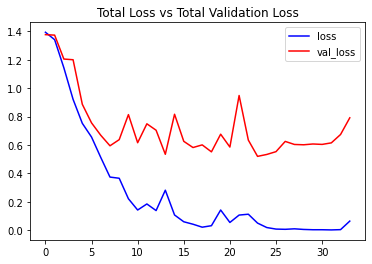

In [20]:
# training and validation loss metrices
plot_metric(convlstm_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')

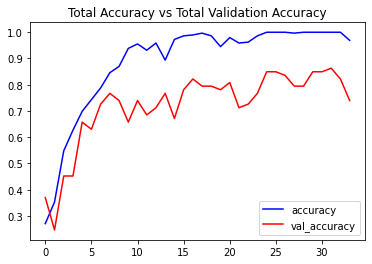

In [21]:
# training and validation accuracy metrices
plot_metric(convlstm_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')

# Approach 2 : LRCN Model

In [10]:
def create_LRCN_model():
  model = Sequential()

  # defining architecture
  model.add(TimeDistributed(Conv2D(16,(3,3), padding = 'same', activation = 'relu'),
                            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH,3)))
  
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))  

  model.add(TimeDistributed(Conv2D(32,(3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32)) # adding a LSTM layer
  model.add(Dense(len(CLASSES_TO_TAKE), activation = 'softmax'))

  #summarising the model
  model.summary()

  return model



In [11]:
# build the LRCN model
LRCN_model = create_LRCN_model()

print("Model built successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

## Compile and train the LRCN model


In [12]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min',restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer='Adam',metrics = ['accuracy'])

LRCN_model_training_history = LRCN_model.fit(x = features_train,y = labels_train, epochs = 70,batch_size = 4,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/70
73/73 [==============================] - 6s 21ms/step - loss: 1.3979 - accuracy: 0.2705 - val_loss: 1.3804 - val_accuracy: 0.2192
Epoch 2/70
73/73 [==============================] - 1s 9ms/step - loss: 1.3635 - accuracy: 0.2979 - val_loss: 1.3665 - val_accuracy: 0.3562
Epoch 3/70
73/73 [==============================] - 1s 9ms/step - loss: 1.3554 - accuracy: 0.3493 - val_loss: 1.3499 - val_accuracy: 0.3562
Epoch 4/70
73/73 [==============================] - 1s 9ms/step - loss: 1.2420 - accuracy: 0.4452 - val_loss: 1.4120 - val_accuracy: 0.2466
Epoch 5/70
73/73 [==============================] - 1s 9ms/step - loss: 1.1602 - accuracy: 0.4863 - val_loss: 1.0907 - val_accuracy: 0.5753
Epoch 6/70
73/73 [==============================] - 1s 10ms/step - loss: 0.9989 - accuracy: 0.5822 - val_loss: 1.4351 - val_accuracy: 0.3973
Epoch 7/70
73/73 [==============================] - 1s 9ms/step - loss: 0.9989 - accuracy: 0.5959 - val_loss: 1.1668 - val_accuracy: 0.4795
Epoch 8/70
73/73 [

In [13]:
model_evaluation_history = LRCN_model.evaluate(features_test,labels_test)

4/4 [==============================] - 1s 73ms/step - loss: 0.3940 - accuracy: 0.9016


## Save the model

In [14]:
# get the loss and accuracy scores
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

data_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt,data_time_format)

model_file_name = f'LRCN_model__Date_Time_{current_date_time_dt}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

## Plots for the LRCN model

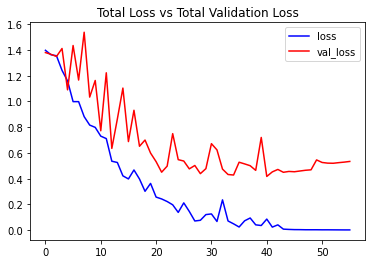

In [17]:
# training and validation loss metrices
plot_metric(LRCN_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')

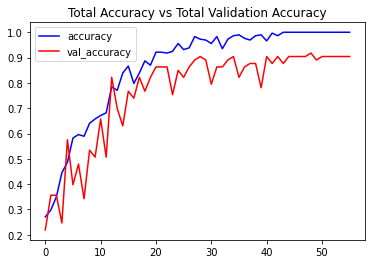

In [18]:
# training and validation accuracy metrices
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')

# Conclusion
The **LRCN** model performed greatly on our dataset compared to the ConvLSTM model both in terms of ```accuracy``` and ```speed```



## Testing on random Youtube samples

In [19]:
def download_yt_videos(youtube_video_url,output_directory):
  video = pafy.new(youtube_video_url) # creating video object
  title = video.title
  video_best = video.getbest() # getting best resolution
  output_file_path = f'{output_directory}/{title}.mp4'
  video_best.download(filepath = output_file_path,quiet = True)

  return title

### Downloading a test video

In [20]:
!pip install youtube-dl==2020.12.2
test_videos_dir = 'test_videos'
os.makedirs(test_videos_dir,exist_ok = True)

video_title = download_yt_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE',test_videos_dir)

input_video_file_path = f'{test_videos_dir}/{video_title}.mp4'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



### Performing action recognition on videos

In [23]:
def predict_on_video(video_file_path,output_file_path,SEQUENCE_LENGTH):
  video_reader = cv2.VideoCapture(video_file_path)
  original_vid_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_vid_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M','P','4','V'),
                                 video_reader.get(cv2.CAP_PROP_FPS), (original_vid_width, original_vid_height))
  
  frames_queue = deque(maxlen = SEQUENCE_LENGTH) # queue to store video frames

  predicted_class_name = '' # variable for predicted class

  while video_reader.isOpened():

    ok, frame = video_reader.read()     # reading the frame
    if not ok:
      break
    
    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT, IMAGE_WIDTH))
    normalised_frame = resized_frame/255
    frames_queue.append(normalised_frame)

    if len(frames_queue) == SEQUENCE_LENGTH:
      predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue,axis=0))[0]
      predicted_label = np.argmax(predicted_labels_probabilities)
      predicted_class_name = CLASSES_TO_TAKE[predicted_label]

    # annotate with class
    cv2.putText(frame,predicted_class_name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    video_writer.write(frame)

  video_reader.release()
  video_writer.release()


In [24]:
output_video_file_path = f'{test_videos_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)
VideoFileClip(output_video_file_path,audio=False,target_resolution=(3300,None)).ipython_display()


100%|██████████| 867/867 [04:01<00:00,  3.58it/s]


In [25]:
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 867/867 [00:03<00:00, 249.62it/s]
